Adapted from https://github.com/hasithsura/Environmental-Sound-Classification/blob/master/ESC50-Pytorch.ipynb

In [1]:
!test ! -f "master.zip" && wget "https://github.com/karoldvl/ESC-50/archive/master.zip"

In [2]:
!unzip -qq master.zip

replace ESC-50-master/.circleci/config.yml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
%cd ESC-50-master

/home/xiaofan/Github/ESC50-torch/ESC-50-master


In [15]:
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os

In [16]:
df = pd.read_csv('meta/esc50.csv')
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [17]:
wav, sr = librosa.load('audio/1-100032-A-0.wav', sr=None)
print(f'Sampling rate of the audio is {sr} and length of the audio is {len(wav)/sr} seconds')

Sampling rate of the audio is 44100 and length of the audio is 5.0 seconds


## Now training and testing on ESC-10

In [18]:
train = df[df['fold']!=5][df['esc10']]
valid = df[df['fold']==5][df['esc10']]

/tmp/ipykernel_991881/1263697058.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = df[df['fold']!=5][df['esc10']]
/tmp/ipykernel_991881/1263697058.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid = df[df['fold']==5][df['esc10']]


In [19]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [20]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
  wav,sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<5*sr:
    wav=np.pad(wav,int(np.ceil((5*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [21]:
class ESC50Data(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df
    self.data = []
    self.labels = []
    self.c2i={}
    self.i2c={}
    self.categories = sorted(df[out_col].unique())
    self.num_classes = 10

    for i, category in enumerate(self.categories):
      self.c2i[category]=i
      self.i2c[i]=category
      
    for ind in tqdm(range(len(df))):
      row = df.iloc[ind]
      file_path = os.path.join(base,row[in_col])
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...])
      self.labels.append(self.c2i[row['category']])

  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
  
train_data = ESC50Data('audio', train, 'filename', 'category')
valid_data = ESC50Data('audio', valid, 'filename', 'category')

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

print(train_data.data[0].shape)

100%|██████████| 80/80 [00:03<00:00, 23.29it/s]

train data length 320
valid data length 80
(1, 128, 431)


In [22]:
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [24]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  2%|▏         | 1/50 [00:01<01:15,  1.54s/it]

Epoch - 1 Train-Loss : 1.216535559296608
Epoch - 1 Valid-Loss : 1.6026102304458618 Valid-Accuracy : 0.575
Epoch - 2 Train-Loss : 0.48299337849020957


  4%|▍         | 2/50 [00:05<02:20,  2.92s/it]

Epoch - 2 Valid-Loss : 0.6124718099832535 Valid-Accuracy : 0.8125
Epoch - 3 Train-Loss : 0.309079971909523


  6%|▌         | 3/50 [00:11<03:25,  4.37s/it]

Epoch - 3 Valid-Loss : 1.0543941795825957 Valid-Accuracy : 0.775
Epoch - 4 Train-Loss : 0.36482579782605173


  8%|▊         | 4/50 [00:22<05:21,  6.99s/it]

Epoch - 4 Valid-Loss : 0.5397028714418411 Valid-Accuracy : 0.85
Epoch - 5 Train-Loss : 0.1608307372778654


 10%|█         | 5/50 [00:29<05:13,  6.97s/it]

Epoch - 5 Valid-Loss : 0.6417389333248138 Valid-Accuracy : 0.8
Epoch - 6 Train-Loss : 0.1764608272816986


 12%|█▏        | 6/50 [00:34<04:43,  6.44s/it]

Epoch - 6 Valid-Loss : 0.8333846807479859 Valid-Accuracy : 0.75
Epoch - 7 Train-Loss : 0.14990635737776756


 14%|█▍        | 7/50 [00:39<04:08,  5.78s/it]

Epoch - 7 Valid-Loss : 0.5822496354579926 Valid-Accuracy : 0.8625
Epoch - 8 Train-Loss : 0.1754675884731114


 16%|█▌        | 8/50 [00:40<03:05,  4.42s/it]

Epoch - 8 Valid-Loss : 0.5517123401165008 Valid-Accuracy : 0.8125


 18%|█▊        | 9/50 [00:42<02:27,  3.59s/it]

Epoch - 9 Train-Loss : 0.08544458355754614
Epoch - 9 Valid-Loss : 0.5456113696098328 Valid-Accuracy : 0.85
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.07781024756841362


 20%|██        | 10/50 [00:44<02:02,  3.06s/it]

Epoch - 10 Valid-Loss : 0.3915220364928246 Valid-Accuracy : 0.8875
Epoch - 11 Train-Loss : 0.04628785247914493


 22%|██▏       | 11/50 [00:46<01:42,  2.62s/it]

Epoch - 11 Valid-Loss : 0.44519373774528503 Valid-Accuracy : 0.8875
Epoch - 12 Train-Loss : 0.021025599259883166


 24%|██▍       | 12/50 [00:47<01:25,  2.25s/it]

Epoch - 12 Valid-Loss : 0.42045131847262385 Valid-Accuracy : 0.8875
Epoch - 13 Train-Loss : 0.0235817531356588


 26%|██▌       | 13/50 [00:49<01:16,  2.06s/it]

Epoch - 13 Valid-Loss : 0.3989639341831207 Valid-Accuracy : 0.9


 28%|██▊       | 14/50 [00:50<01:10,  1.96s/it]

Epoch - 14 Train-Loss : 0.0243229859508574
Epoch - 14 Valid-Loss : 0.45895494893193245 Valid-Accuracy : 0.8625


 30%|███       | 15/50 [00:51<00:59,  1.69s/it]

Epoch - 15 Train-Loss : 0.020500682457350195
Epoch - 15 Valid-Loss : 0.41191557347774505 Valid-Accuracy : 0.8875


 32%|███▏      | 16/50 [00:53<00:52,  1.53s/it]

Epoch - 16 Train-Loss : 0.021298347297124563
Epoch - 16 Valid-Loss : 0.40484215319156647 Valid-Accuracy : 0.8875


 34%|███▍      | 17/50 [00:54<00:47,  1.43s/it]

Epoch - 17 Train-Loss : 0.013175689545460046
Epoch - 17 Valid-Loss : 0.3924712985754013 Valid-Accuracy : 0.9


 36%|███▌      | 18/50 [00:55<00:43,  1.35s/it]

Epoch - 18 Train-Loss : 0.03462379251141101
Epoch - 18 Valid-Loss : 0.3923877030611038 Valid-Accuracy : 0.8875


 38%|███▊      | 19/50 [00:56<00:40,  1.29s/it]

Epoch - 19 Train-Loss : 0.013955318881198765
Epoch - 19 Valid-Loss : 0.37505804747343063 Valid-Accuracy : 0.9
Changed learning rate to 2e-06


 40%|████      | 20/50 [00:57<00:38,  1.29s/it]

Epoch - 20 Train-Loss : 0.012139834422850982
Epoch - 20 Valid-Loss : 0.39667961597442625 Valid-Accuracy : 0.9125


 42%|████▏     | 21/50 [00:59<00:40,  1.40s/it]

Epoch - 21 Train-Loss : 0.011714459373615682
Epoch - 21 Valid-Loss : 0.3822563156485558 Valid-Accuracy : 0.9


 44%|████▍     | 22/50 [01:01<00:41,  1.49s/it]

Epoch - 22 Train-Loss : 0.01111947714816779
Epoch - 22 Valid-Loss : 0.38521492183208467 Valid-Accuracy : 0.9125


 46%|████▌     | 23/50 [01:02<00:41,  1.54s/it]

Epoch - 23 Train-Loss : 0.01124183660140261
Epoch - 23 Valid-Loss : 0.37696260362863543 Valid-Accuracy : 0.9125


 48%|████▊     | 24/50 [01:04<00:40,  1.56s/it]

Epoch - 24 Train-Loss : 0.012500510760582983
Epoch - 24 Valid-Loss : 0.40478902608156203 Valid-Accuracy : 0.9125


 50%|█████     | 25/50 [01:06<00:39,  1.59s/it]

Epoch - 25 Train-Loss : 0.011411024117842316
Epoch - 25 Valid-Loss : 0.3870611399412155 Valid-Accuracy : 0.9


 52%|█████▏    | 26/50 [01:07<00:38,  1.62s/it]

Epoch - 26 Train-Loss : 0.018720649229362608
Epoch - 26 Valid-Loss : 0.43340565264225006 Valid-Accuracy : 0.8875


 54%|█████▍    | 27/50 [01:09<00:37,  1.65s/it]

Epoch - 27 Train-Loss : 0.013146685808897019
Epoch - 27 Valid-Loss : 0.40045792758464815 Valid-Accuracy : 0.925


 56%|█████▌    | 28/50 [01:11<00:36,  1.64s/it]

Epoch - 28 Train-Loss : 0.01500641549937427
Epoch - 28 Valid-Loss : 0.4289184398949146 Valid-Accuracy : 0.9
Epoch - 29 Train-Loss : 0.01850821457337588


 58%|█████▊    | 29/50 [01:13<00:36,  1.73s/it]

Epoch - 29 Valid-Loss : 0.3872478663921356 Valid-Accuracy : 0.9125
Changed learning rate to 2.0000000000000002e-07


 60%|██████    | 30/50 [01:14<00:34,  1.72s/it]

Epoch - 30 Train-Loss : 0.00862404318759218
Epoch - 30 Valid-Loss : 0.39977552741765976 Valid-Accuracy : 0.9


 62%|██████▏   | 31/50 [01:16<00:32,  1.69s/it]

Epoch - 31 Train-Loss : 0.016781737410929053
Epoch - 31 Valid-Loss : 0.39546987414360046 Valid-Accuracy : 0.9125


 64%|██████▍   | 32/50 [01:18<00:30,  1.67s/it]

Epoch - 32 Train-Loss : 0.010953892278485
Epoch - 32 Valid-Loss : 0.4073725625872612 Valid-Accuracy : 0.9125


 66%|██████▌   | 33/50 [01:19<00:28,  1.67s/it]

Epoch - 33 Train-Loss : 0.014224386925343424
Epoch - 33 Valid-Loss : 0.35872332751750946 Valid-Accuracy : 0.925


 68%|██████▊   | 34/50 [01:21<00:26,  1.65s/it]

Epoch - 34 Train-Loss : 0.010094997601117938
Epoch - 34 Valid-Loss : 0.3943109199404716 Valid-Accuracy : 0.9125


 70%|███████   | 35/50 [01:22<00:24,  1.65s/it]

Epoch - 35 Train-Loss : 0.012781578756403178
Epoch - 35 Valid-Loss : 0.3850931733846664 Valid-Accuracy : 0.9


 72%|███████▏  | 36/50 [01:24<00:22,  1.60s/it]

Epoch - 36 Train-Loss : 0.016721997386775912
Epoch - 36 Valid-Loss : 0.4067431926727295 Valid-Accuracy : 0.9125


 74%|███████▍  | 37/50 [01:25<00:19,  1.47s/it]

Epoch - 37 Train-Loss : 0.012544490816071629
Epoch - 37 Valid-Loss : 0.40434481799602506 Valid-Accuracy : 0.9125


 76%|███████▌  | 38/50 [01:26<00:16,  1.38s/it]

Epoch - 38 Train-Loss : 0.016023671079892665
Epoch - 38 Valid-Loss : 0.38604231383651494 Valid-Accuracy : 0.9125


 78%|███████▊  | 39/50 [01:27<00:14,  1.31s/it]

Epoch - 39 Train-Loss : 0.007763086096383631
Epoch - 39 Valid-Loss : 0.39554571360349655 Valid-Accuracy : 0.9125
Changed learning rate to 2e-08


 80%|████████  | 40/50 [01:29<00:12,  1.27s/it]

Epoch - 40 Train-Loss : 0.007761967356782406
Epoch - 40 Valid-Loss : 0.3897732824087143 Valid-Accuracy : 0.925


 82%|████████▏ | 41/50 [01:30<00:11,  1.25s/it]

Epoch - 41 Train-Loss : 0.015606217086315155
Epoch - 41 Valid-Loss : 0.41559149622917174 Valid-Accuracy : 0.9125


 84%|████████▍ | 42/50 [01:31<00:09,  1.22s/it]

Epoch - 42 Train-Loss : 0.020498254359699784
Epoch - 42 Valid-Loss : 0.407160085439682 Valid-Accuracy : 0.925


 86%|████████▌ | 43/50 [01:32<00:08,  1.21s/it]

Epoch - 43 Train-Loss : 0.008853848953731359
Epoch - 43 Valid-Loss : 0.43166000097990037 Valid-Accuracy : 0.9


 88%|████████▊ | 44/50 [01:33<00:07,  1.19s/it]

Epoch - 44 Train-Loss : 0.011598314216826111
Epoch - 44 Valid-Loss : 0.3956568092107773 Valid-Accuracy : 0.9125


 90%|█████████ | 45/50 [01:34<00:05,  1.19s/it]

Epoch - 45 Train-Loss : 0.01385271423496306
Epoch - 45 Valid-Loss : 0.40510132983326913 Valid-Accuracy : 0.9125


 92%|█████████▏| 46/50 [01:36<00:04,  1.19s/it]

Epoch - 46 Train-Loss : 0.01433263811049983
Epoch - 46 Valid-Loss : 0.39389600306749345 Valid-Accuracy : 0.925


 94%|█████████▍| 47/50 [01:37<00:03,  1.18s/it]

Epoch - 47 Train-Loss : 0.014969598210882396
Epoch - 47 Valid-Loss : 0.39835560917854307 Valid-Accuracy : 0.9125


 96%|█████████▌| 48/50 [01:38<00:02,  1.18s/it]

Epoch - 48 Train-Loss : 0.009162725659552961
Epoch - 48 Valid-Loss : 0.4077347472310066 Valid-Accuracy : 0.9


 98%|█████████▊| 49/50 [01:39<00:01,  1.18s/it]

Epoch - 49 Train-Loss : 0.01342359253903851
Epoch - 49 Valid-Loss : 0.40857768803834915 Valid-Accuracy : 0.9125
Changed learning rate to 2e-09


100%|██████████| 50/50 [01:40<00:00,  2.02s/it]

Epoch - 50 Train-Loss : 0.010189953481312842
Epoch - 50 Valid-Loss : 0.39379120245575905 Valid-Accuracy : 0.9125


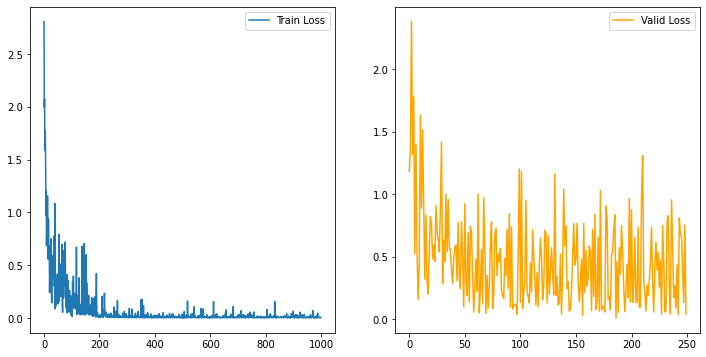

In [25]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


## Visualization to help understanding

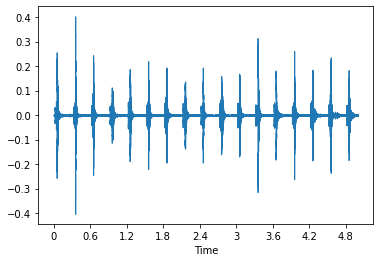

In [26]:
import librosa.display
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr=sr)

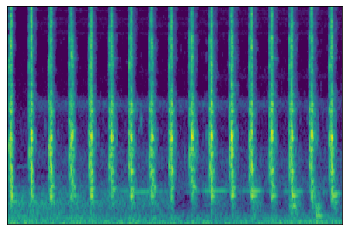

In [27]:
librosa.display.specshow(spec_to_image(get_melspectrogram_db('audio/'+filename, sr)), cmap='viridis')